In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
zip_path = '/content/drive/MyDrive/CNNDataset.zip'
extract_path = '/content/CNNDataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
extracted_contents = os.listdir(extract_path)
print(extracted_contents)

['vehicles', 'dogs', 'food']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
df = '/content/CNNDataset'

In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = datasets.ImageFolder(root=df)
classes = dataset.classes
print("Number of classes:", len(classes))
print("Class names:", classes)

Number of classes: 3
Class names: ['dogs', 'food', 'vehicles']


In [ ]:
# Data Normalisation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = datasets.ImageFolder(root=df, transform=transform)

In [ ]:
print("Number of images:", len(dataset))
print("Number of classes:", len(classes))

Number of images: 30000
Number of classes: 3


In [ ]:
class_to_one_hot = {class_idx: torch.nn.functional.one_hot(torch.tensor(class_idx), num_classes=len(classes)) for class_idx in range(len(classes))}
for class_idx, one_hot_vector in class_to_one_hot.items():
    print(f"Class {classes[class_idx]} - Class Index: {class_idx}, One-Hot Encoded: {one_hot_vector}")

Class dogs - Class Index: 0, One-Hot Encoded: tensor([1, 0, 0])
Class food - Class Index: 1, One-Hot Encoded: tensor([0, 1, 0])
Class vehicles - Class Index: 2, One-Hot Encoded: tensor([0, 0, 1])


In [ ]:
def show_images(images, labels, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, img, label in zip(axes, images, labels):
        if isinstance(img, torch.Tensor):
            img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(classes[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

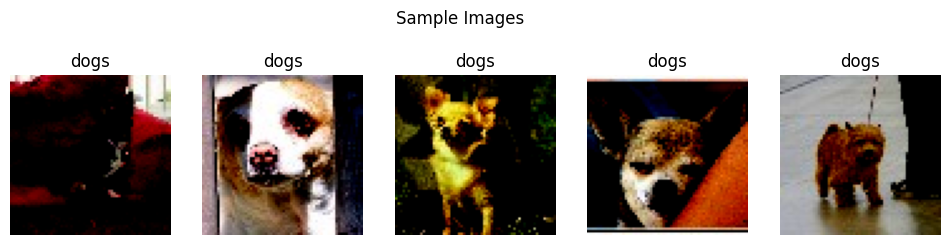

In [ ]:
sample_images, sample_labels = zip(*[dataset[i] for i in range(5)])
show_images(sample_images, sample_labels, "Sample Images")

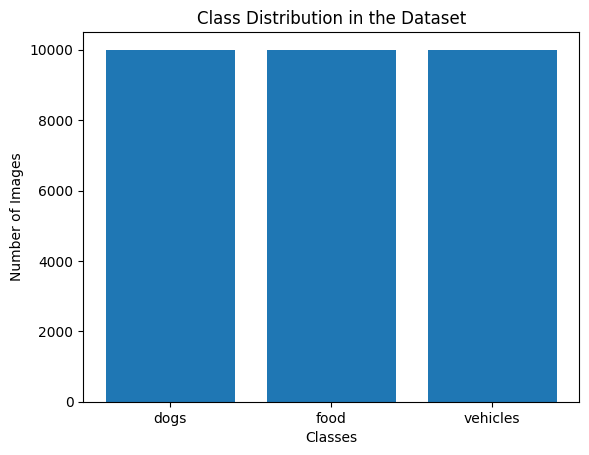

In [ ]:
class_counts = [0] * len(classes)
for _, label in dataset:
    class_counts[label] += 1

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print("Training set shape:", len(train_data))
print("Validation set shape:", len(val_data))
print("Test set shape:", len(test_data))

Training set shape: 24000
Validation set shape: 3000
Test set shape: 3000


In [ ]:
#VGG13 (version B) architecture
class CustomVGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomVGG13, self).__init__()
        self.conv_stack = nn.Sequential(
            # First convolutional layer:
            nn.Conv2d(3, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(64, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Max pooling layer:
            nn.MaxPool2d(2, 2),
            # Third convolutional layer:
            nn.Conv2d(64, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Fourth convolutional layer:
            nn.Conv2d(128, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Max pooling layer:
            nn.MaxPool2d(2, 2),
            # Fifth convolutional layer:
            nn.Conv2d(128, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Sixth convolutional layer:
            nn.Conv2d(256, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Seventh convolutional layer:
            nn.Conv2d(256, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Eight convolutional layer:
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Ninth convolutional layer:
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            # Tenth convolutional layer:
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.lin_stack = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.lin_stack(x)
        return x


In [ ]:
model = CustomVGG13(num_classes=len(classes)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/5: 100%|██████████| 375/375 [00:26<00:00, 13.90it/s]


Epoch 1/5, Validation Loss: 0.5109916069406144, Validation Accuracy: 0.773


Epoch 2/5: 100%|██████████| 375/375 [00:26<00:00, 14.09it/s]


Epoch 2/5, Validation Loss: 0.4056728123984438, Validation Accuracy: 0.843


Epoch 3/5: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


Epoch 3/5, Validation Loss: 0.37982379248801695, Validation Accuracy: 0.849


Epoch 4/5: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


Epoch 4/5, Validation Loss: 0.2931993086921408, Validation Accuracy: 0.8916666666666667


Epoch 5/5: 100%|██████████| 375/375 [00:26<00:00, 13.90it/s]


Epoch 5/5, Validation Loss: 0.3107313783244884, Validation Accuracy: 0.8843333333333333


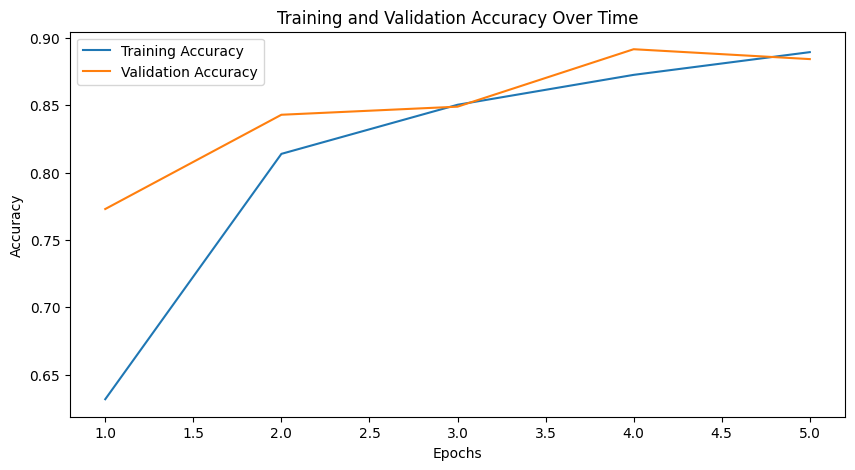

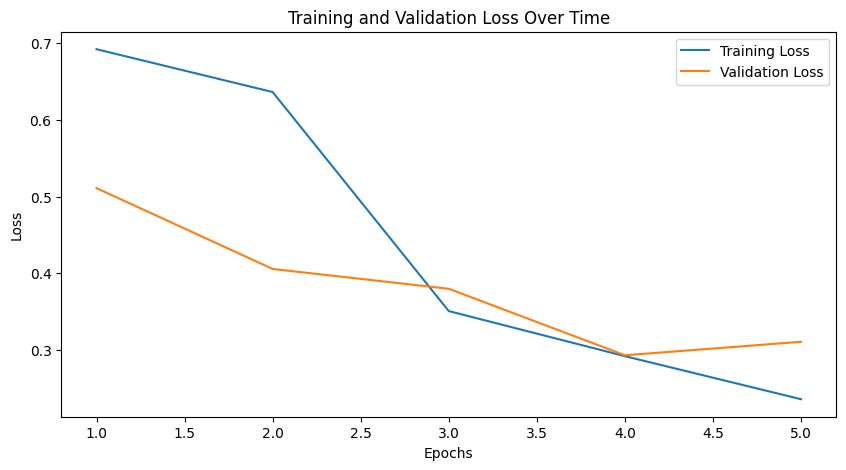

Final Test Accuracy: 0.8863333333333333


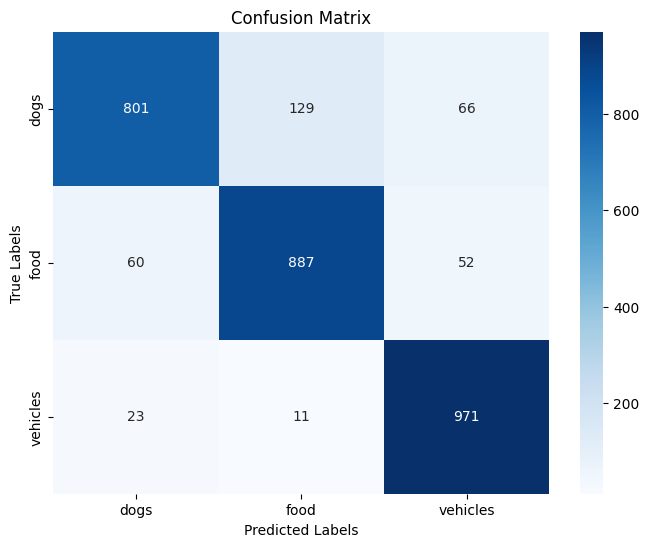

In [ ]:
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Training the model
epochs = 5
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    # Iterate over training data
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()
    # Calculate training accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = loss.item()

    # Below evaluating the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        # Below evaluating the validation set
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.squeeze()).item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()
        # Calculate validation accuracy and loss
        val_accuracy = correct_val / total_val
        val_loss /= len(val_loader)
        # # Calculate training accuracy and loss
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plotting the graph between training, validation accuracies
epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting graph between training, validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating the test dataset
model.eval()
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    # Iterate over testing data
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels.squeeze()).item()
        _, predicted_test = outputs.max(1)

        all_predicted_labels.extend(predicted_test.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

        total_test += labels.size(0)
        correct_test += predicted_test.eq(labels).sum().item()

    test_accuracy = correct_test / total_test
    print(f"Final Test Accuracy: {test_accuracy}")

cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Confusion matrix between predicted labels and true labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Regularization

In [ ]:
# Adding regularization to the architecture
class RegularizationVGG13(nn.Module):
    def __init__(self, num_classes=3, weight_decay=0.001):
        super(RegularizationVGG13, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.lin_stack = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.lin_stack(x)
        return x

In [ ]:
model = RegularizationVGG13(num_classes=len(classes), weight_decay=0.001).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=.0001, weight_decay=0.0001)


Epoch 1/5: 100%|██████████| 375/375 [00:27<00:00, 13.79it/s]


Epoch 1/5, Validation Loss: 0.251684197085969, Validation Accuracy: 0.908


Epoch 2/5: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


Epoch 2/5, Validation Loss: 0.2465881827346822, Validation Accuracy: 0.91


Epoch 3/5: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


Epoch 3/5, Validation Loss: 0.2665934939967825, Validation Accuracy: 0.9066666666666666


Epoch 4/5: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


Epoch 4/5, Validation Loss: 0.2203283723681531, Validation Accuracy: 0.918


Epoch 5/5: 100%|██████████| 375/375 [00:26<00:00, 14.04it/s]


Epoch 5/5, Validation Loss: 0.20225629781154877, Validation Accuracy: 0.9246666666666666


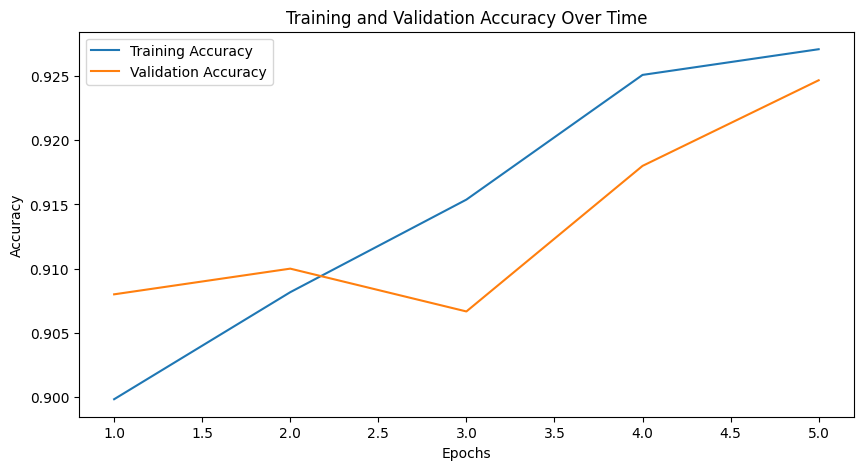

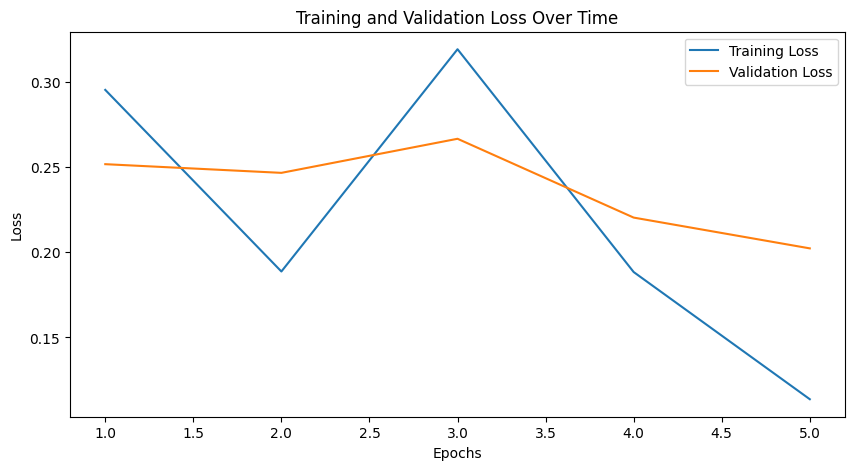

Final Test Accuracy: 0.9263333333333333


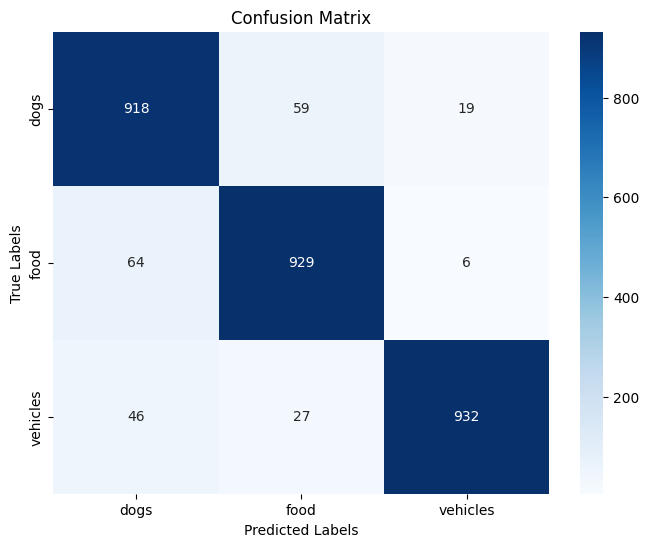

In [ ]:
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Training the model
epochs = 5
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = loss.item()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.squeeze()).item()  # Ensure labels is a 1D tensor
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

        val_accuracy = correct_val / total_val
        val_loss /= len(val_loader)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plotting the graph between training and validation accuracy
epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the graph between training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the test dataset
model.eval()
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels.squeeze()).item()
        _, predicted_test = outputs.max(1)

        all_predicted_labels.extend(predicted_test.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

        total_test += labels.size(0)
        correct_test += predicted_test.eq(labels).sum().item()

    test_accuracy = correct_test / total_test
    print(f"Final Test Accuracy: {test_accuracy}")

# Generate and plot the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'RegularizationVGG13_weights.pth')

## Dropouts

In [ ]:
#Adding the Dropout to the VGG model architecture
class DropoutVGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(DropoutVGG13, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.lin_stack = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.lin_stack(x)
        return x


In [ ]:
model = DropoutVGG13(num_classes=len(classes)).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/5: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


Epoch 1/5, Validation Loss: 0.4542005994218461, Validation Accuracy: 0.832


Epoch 2/5: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


Epoch 2/5, Validation Loss: 0.4144445984287465, Validation Accuracy: 0.8406666666666667


Epoch 3/5: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


Epoch 3/5, Validation Loss: 0.32041925033356283, Validation Accuracy: 0.8796666666666667


Epoch 4/5: 100%|██████████| 375/375 [00:26<00:00, 14.10it/s]


Epoch 4/5, Validation Loss: 0.2529142472021123, Validation Accuracy: 0.908


Epoch 5/5: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


Epoch 5/5, Validation Loss: 0.2714163838548863, Validation Accuracy: 0.901


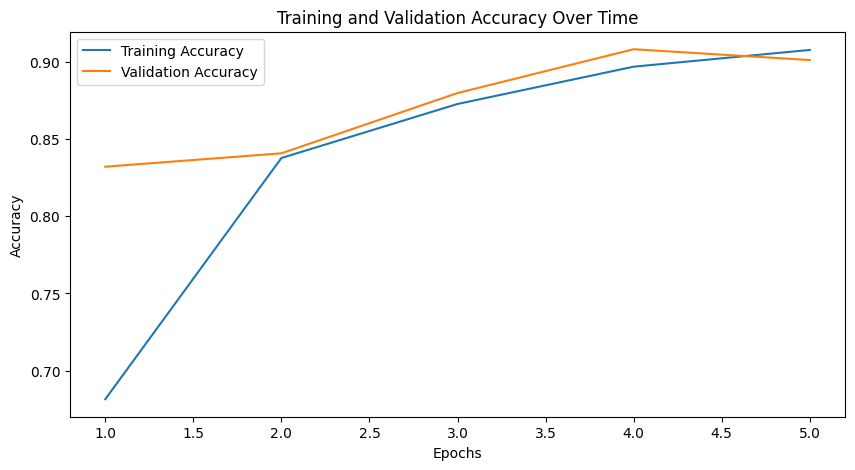

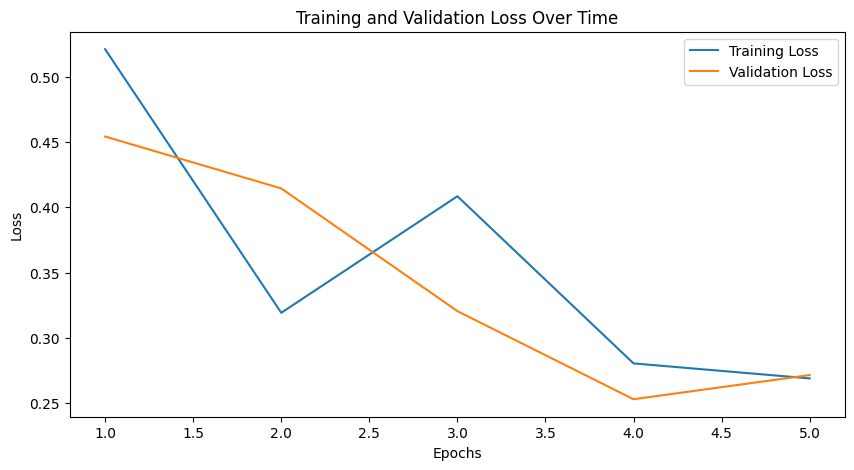

Final Test Accuracy: 0.9073333333333333


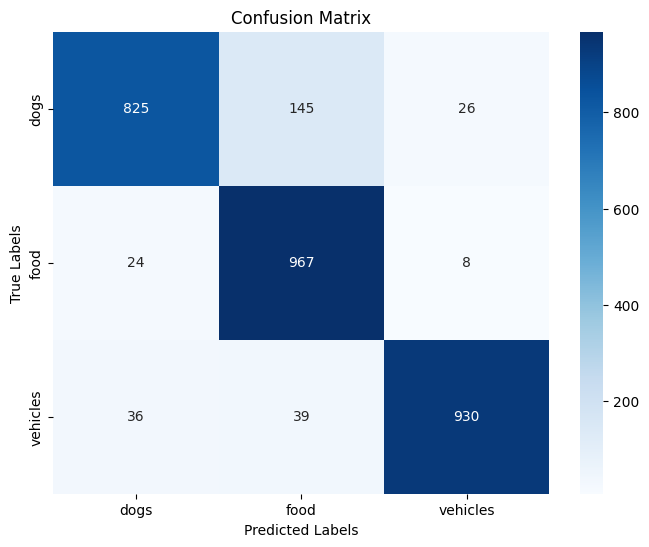

In [ ]:
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Training the model
epochs = 5
for epoch in range(epochs):
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # Ensure labels is a 1D tensor
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = loss.item()

    # Evaluating the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.squeeze()).item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

        val_accuracy = correct_val / total_val
        val_loss /= len(val_loader)

        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Plotting the graph between training accuracy and validation accuracy
epochs_range = range(1, epochs+1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracy_list, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the graph between training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on the test set and generate confusion matrix
model.eval()
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels.squeeze()).item()
        _, predicted_test = outputs.max(1)

        all_predicted_labels.extend(predicted_test.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

        total_test += labels.size(0)
        correct_test += predicted_test.eq(labels).sum().item()

    test_accuracy = correct_test / total_test
    print(f"Final Test Accuracy: {test_accuracy}")

# Generate and plot the confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## early stopping

In [ ]:
# Adding  early stopping
class earlyStoppingVGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(earlyStoppingVGG13, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1, stride=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.lin_stack = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.lin_stack(x)
        return x


In [ ]:
model = earlyStoppingVGG13(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 100
early_stopping_patience = 2

best_val_loss = float('inf')
current_patience = 0
# Training the model
for epoch in range(epochs):
    model.train()
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()   # Backpropagation
        optimizer.step()   # Update weights

# Evaluating the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.squeeze()).item()
            _, predicted_val = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted_val.eq(labels).sum().item()

        val_accuracy = correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
                break

# Evaluating on the test set
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels.squeeze()).item()  # Ensure labels is a 1D tensor
            _, predicted_test = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted_test.eq(labels).sum().item()

        test_accuracy = correct_test / total_test
        print(f"Final Test Accuracy: {test_accuracy}")


Epoch 1/100: 100%|██████████| 375/375 [00:26<00:00, 14.20it/s]


Epoch 1/100, Validation Loss: 0.4337264064778673, Validation Accuracy: 0.83
Final Test Accuracy: 0.82


Epoch 2/100: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


Epoch 2/100, Validation Loss: 0.3484502691537776, Validation Accuracy: 0.8663333333333333
Final Test Accuracy: 0.8703333333333333


Epoch 3/100: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


Epoch 3/100, Validation Loss: 0.3309785581015526, Validation Accuracy: 0.8883333333333333
Final Test Accuracy: 0.8853333333333333


Epoch 4/100: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


Epoch 4/100, Validation Loss: 0.2969902975762144, Validation Accuracy: 0.8893333333333333
Final Test Accuracy: 0.8906666666666667


Epoch 5/100: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


Epoch 5/100, Validation Loss: 0.3322141227569986, Validation Accuracy: 0.8713333333333333
Final Test Accuracy: 0.873


Epoch 6/100: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


Epoch 6/100, Validation Loss: 0.2646123803359397, Validation Accuracy: 0.902
Final Test Accuracy: 0.9056666666666666


Epoch 7/100: 100%|██████████| 375/375 [00:25<00:00, 14.49it/s]


Epoch 7/100, Validation Loss: 0.2835500031075579, Validation Accuracy: 0.8956666666666667
Final Test Accuracy: 0.8863333333333333


Epoch 8/100: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


Epoch 8/100, Validation Loss: 0.2709858842352603, Validation Accuracy: 0.8986666666666666
Early stopping at epoch 8 due to no improvement in validation loss.


In [ ]:
torch.save(model.state_dict(), 'earlyStoppingVGG13_weights.pth')

## image augmentation

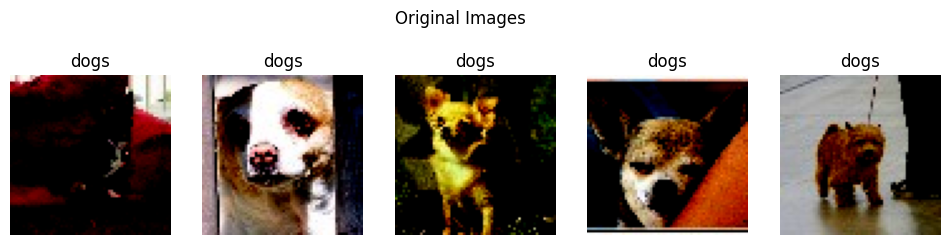

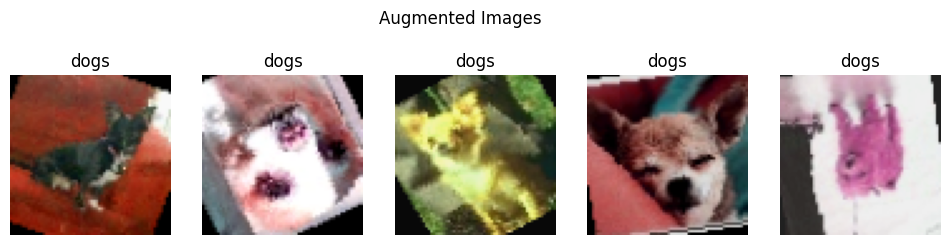

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip with probability 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with probability 0.5
    transforms.RandomRotation(degrees=30),  # Random rotation with maximum angle of 30 degrees
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Random resized crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),   # Color jitter
])

# Augmenting the dataset
augmented_dataset = datasets.ImageFolder(root=df, transform=augmentation_transform)

# Showing original and augmented images
sample_original_images, sample_original_labels = zip(*[dataset[i] for i in range(5)])
show_images(sample_original_images, sample_original_labels, "Original Images")

sample_augmented_images, sample_augmented_labels = zip(*[augmented_dataset[i] for i in range(5)])
show_images(sample_augmented_images, sample_augmented_labels, "Augmented Images")